In [1]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'



train_normal = glob.glob(train_path + "/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path + "/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path + "/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path + "/PNEUMONIA/*.jpeg")

In [3]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [4]:
df_train


,class,image
0,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0771-0001.jpeg
1,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg
2,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0675-0001.jpeg
3,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1169-0001.jpeg
4,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0421-0001.jpeg
...,...,...
5211,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1541_virus_2681.jpeg
5212,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person799_virus_1431.jpeg
5213,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person931_virus_1592.jpeg
5214,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person861_virus_1506.jpeg


In [5]:
df_test


,class,image
0,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0336-0001.jpeg
1,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0101-0001.jpeg
2,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0337-0001.jpeg
3,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0198-0001.jpeg
4,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0013-0001.jpeg
...,...,...
619,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1659_virus_2867.jpeg
620,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1615_virus_2801.jpeg
621,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1664_virus_2877.jpeg
622,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person111_bacteria_536.jpeg


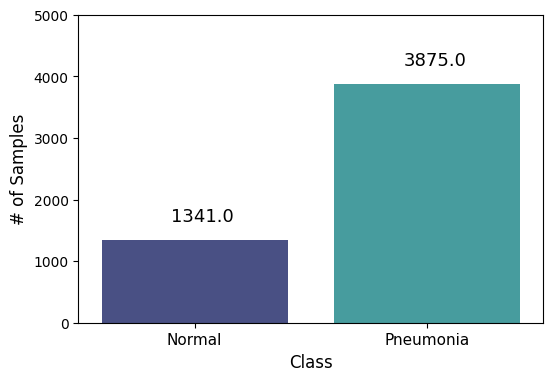

In [6]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

In [7]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [8]:
train_df

,class,image
99,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0523-0001-0001.jpeg
1284,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0602-0001.jpeg
5142,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person611_bacteria_2476.jpeg
1365,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1197_virus_2039.jpeg
2649,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1023_bacteria_2954.jpeg
...,...,...
4481,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1548_bacteria_4048.jpeg
2404,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1198_bacteria_3148.jpeg
705,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0549-0001.jpeg
3732,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person981_bacteria_2908.jpeg


In [9]:
val_df

,class,image
1977,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person442_virus_906.jpeg
2328,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person427_bacteria_1866.jpeg
4344,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person823_virus_1459.jpeg
956,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0551-0001-0001.jpeg
3753,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1038_bacteria_2972.jpeg
...,...,...
3339,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person50_bacteria_238.jpeg
1368,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person318_bacteria_1474.jpeg
1585,Pneumonia,/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person73_bacteria_359.jpeg
1128,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1412-0001.jpeg


In [10]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [11]:
import os, random, gc, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
# import keras_preprocessing.image
import tensorflow.keras.backend as k
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Input, AvgPool2D, Conv2D
from tensorflow.keras.layers import multiply, concatenate, Lambda, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
from PIL import Image

In [12]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121, InceptionV3

tf.keras.backend.clear_session()

IMG_SIZE = (224, 224)
NUM_CLASSES = 1

def get_combined_model():
 
    common_input = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='common_input')

    # DenseNet121 model 
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=common_input)
    densenet_output = GlobalAveragePooling2D()(densenet_base.output)

    # InceptionV3 model 
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=common_input)
    inception_output = GlobalAveragePooling2D()(inception_base.output)

    # Concatenate the outputs of both models
    combined_output = concatenate([densenet_output, inception_output])

    # Add some fully connected layers for classification
    x = Dense(128, activation='relu')(combined_output)
    x = Dropout(0.1)(x)
    
  

    # Output layer
    output = Dense(NUM_CLASSES, activation='sigmoid')(x)

    # Create the combined model
    model = Model(inputs=common_input, outputs=output)

    return model

# Create the combined model
combined_model = get_combined_model()

# Compile the model with the desired optimizer, loss function, and metrics
combined_model.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5), metrics='accuracy')

# Print a summary of the model architecture
combined_model.summary()


87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 common_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['common_input[0][0]']           
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [13]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 5,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [14]:
history = combined_model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 388s 2s/step - loss: 0.1405 - accuracy: 0.9444 - val_loss: 0.5486 - val_accuracy: 0.7759 - lr: 5.0000e-05
Epoch 2/50
130/130 [==============================] - 188s 1s/step - loss: 0.0576 - accuracy: 0.9787 - val_loss: 0.5605 - val_accuracy: 0.7835 - lr: 5.0000e-05
Epoch 3/50
130/130 [==============================] - 194s 1s/step - loss: 0.0369 - accuracy: 0.9875 - val_loss: 0.0447 - val_accuracy: 0.9847 - lr: 5.0000e-05
Epoch 4/50
130/130 [==============================] - 190s 1s/step - loss: 0.0242 - accuracy: 0.9926 - val_loss: 0.0637 - val_accuracy: 0.9741 - lr: 5.0000e-05
Epoch 5/50
130/130 [==============================] - 192s 1s/step - loss: 0.0384 - accuracy: 0.9866 - val_loss: 0.0602 - val_accuracy: 0.9732 - lr: 5.0000e-05
Epoch 6/50
130/130 [==============================] - 194s 1s/step - loss: 0.0283 - accuracy: 0.9909 - val_loss: 0.1790 - val_accuracy: 0.9464 - lr: 5.0000e-05
Epoch 7/50
130/130 [====================

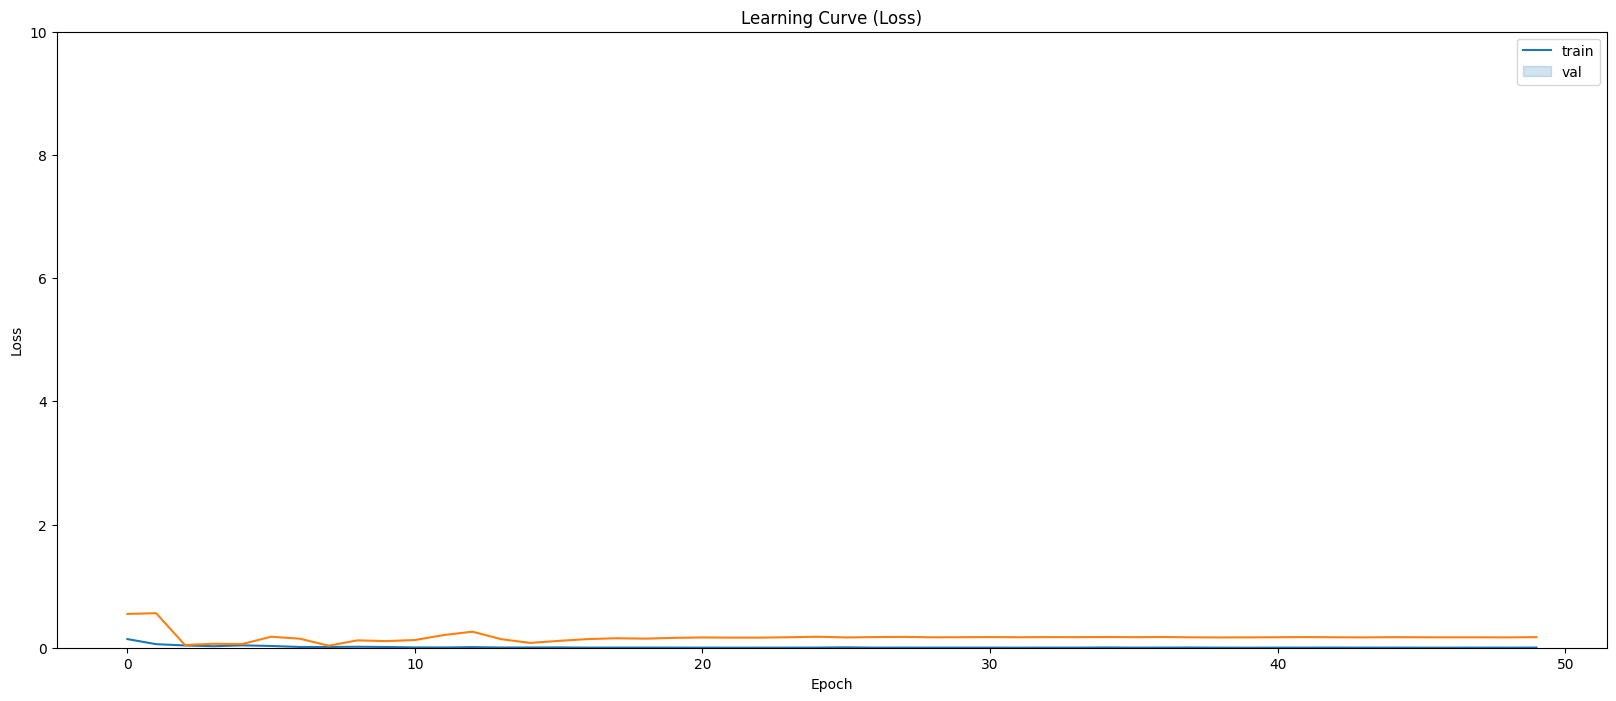

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 10)
ax.legend(['train', 'val'], loc='best')
plt.show()

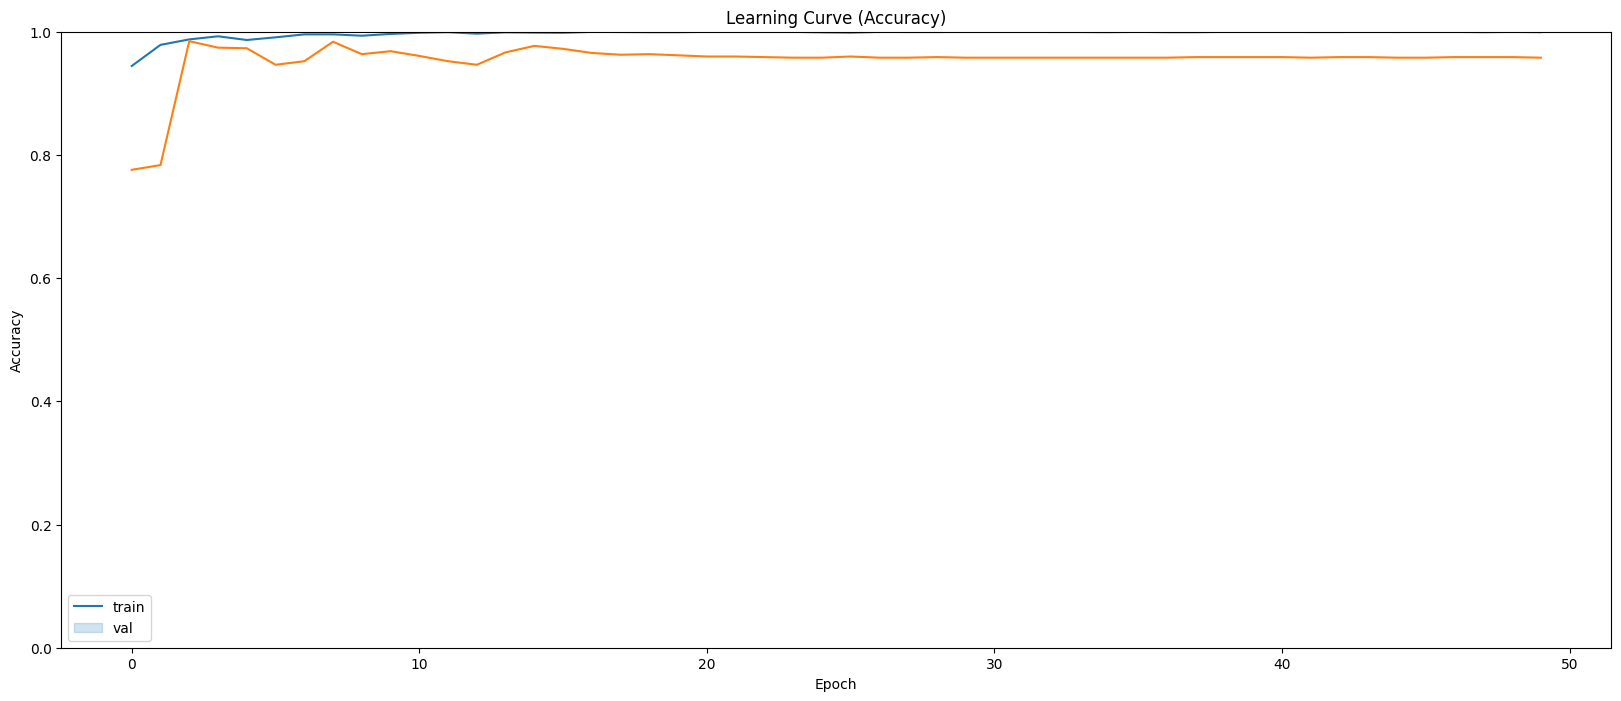

In [16]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()


In [17]:
score = combined_model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1714305430650711
Val accuracy: 0.9578543901443481


In [18]:
score = combined_model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3031969368457794
Test accuracy: 0.9294871687889099


In [19]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [20]:
ds_test.reset()
predictions = combined_model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [21]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9294871794871795


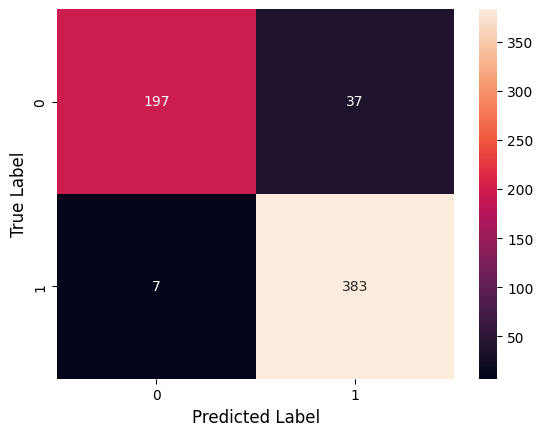

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       234
           1       0.91      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



In [22]:
from tensorflow.keras.metrics import Metric
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import f1_score,roc_auc_score
confusion_mat = confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_mat, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()
print(classification_report(Y_test, pred_labels, labels = [0, 1]))

ROC_AUC:  0.9831415735261889


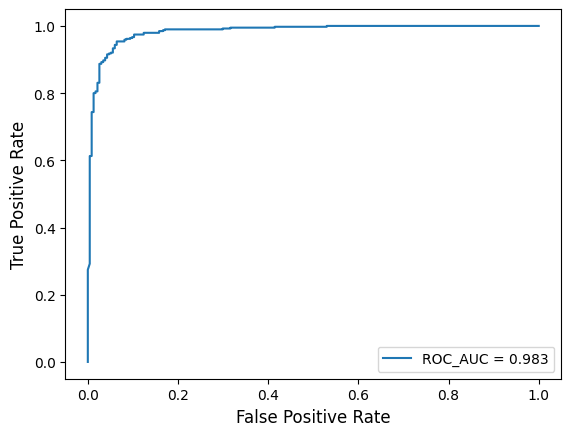

In [23]:
from sklearn.metrics import f1_score,roc_auc_score,roc_curve
roc_auc = roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()